<a href="https://colab.research.google.com/github/fadeevie/stitching_imgs/blob/main/Fadeev_lr3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Сшивание изображений**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

*Функция для обнаружения ключевых точек и их дескрипторов*

In [ ]:
def detect(img):
  orb = cv2.ORB_create() #cоздаём объект ORB для обнаружения и описания ключевых точек
  keypoints, descriptors = orb.detectAndCompute(img, None) #обнаруживаем ключевые точки и вычисляем их дескрипторы на изображении
  return keypoints, descriptors #возвращаем ключевые точки и дескрипторы

*Функция для сопоставления ключевых точек по дескрипторам*

In [ ]:
def match_keypoints(desc1, desc2, threshold=50):
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) #создаём объект BFMatcher для сопоставления дескрипторов
  matches = bf.match(desc1, desc2) #выполняем сопоставление дескрипторов
  matches = [m for m in matches if m.distance < threshold] #отбираем только те совпадения, которые находятся ниже заданного порога
  matches = sorted(matches, key=lambda x: x.distance) #сортируем совпадения по расстоянию
  return matches #возвращаем отфильтрованные и отсортированные совпадения

*Функция для вычисления гомографии между двумя наборами ключевых точек*

In [ ]:
def homography(kp1, kp2, matches):
  src_pnts = np.float32([kp1[i.queryIdx].pt for i in matches]).reshape(-1, 1, 2) #извлекаем координаты ключевых точек из первого изображения
  dst_pnts = np.float32([kp2[i.trainIdx].pt for i in matches]).reshape(-1, 1, 2) #извлекаем координаты ключевых точек из второго изображения
  h_graph, mask = cv2.findHomography(src_pnts, dst_pnts, cv2.RANSAC, 5.0) #вычисляем матрицу гомографии с помощью алгоритма RANSAC
  return h_graph, mask #возвращаем матрицу гомографии и маску

*Функция для сшивания списка изображений*

In [ ]:
def stitch_imgs(imgs):
  stitch_img = imgs[0] # начальное изображение для сшивания
  H_total = np.eye(3) # инициализация общей гомографии как единичной матрицы

  for i in range(1, len(imgs)):
    img1 = stitch_img #определяем текущее сшитое изображение и следующее изображение
    img2 = imgs[i] #определяем следующее изображение

    #Обнаруживаем ключевые точки и дескрипторы для обоих изображений.
    kp1, desc1 = detect(img1)
    kp2, desc2 = detect(img2)

    matches = match_keypoints(desc1, desc2) #cопоставляем ключевые точки

    #Проверяем, достаточно ли совпадений для надёжного вычисления гомографии
    if len(matches) < 4:
      print('Недостаточно элементов для совпадения:', i)
      continue

    h_graph, mask = homography(kp1, kp2, matches) #вычисляем матрицу гомографии
    H_total = H_total.dot(h_graph) #обновляем общую гомографию


    #Определяем размеры результирующего изображения

    #Получаем размеры изображений
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    corners_img1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2) #координаты углов первого изображения
    corners_img2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2) #координаты углов второго изображения
    corners_img2_trans = cv2.perspectiveTransform(corners_img2, h_graph) #преобразуем углы второго изображения по гомографии

    all_corners = np.concatenate((corners_img1, corners_img2_trans), axis=0) #объединяем углы обоих изображений

    #Находим минимальные и максимальные координаты для итогового изображения
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation_dist = [-xmin, -ymin] #рассчитываем сдвиг для преобразования
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]]) #матрица для сдвига изображения
    result = cv2.warpPerspective(img1, H_translation.dot(h_graph), (xmax - xmin, ymax - ymin)) #применяем гомографию и сдвиг для первого изображения
    result[translation_dist[1]:translation_dist[1] + height2, translation_dist[0]:translation_dist[0] + width2] = img2 #копируем второе изображение на соответствующее место в результирующем изображении

    # width = img1.shape[1] + img2.shape[1]
    # height = img1.shape[0] + img2.shape[0]
    # result = cv2.warpPerspective(img1, h_graph, (width, height))
    # result[0:img2.shape[0], 0:img2.shape[1]] = img2
    stitch_img = result #обновляем результирующее изображение для следующей итерации

  return stitch_img #возвращаем окончательное сшитое изображение


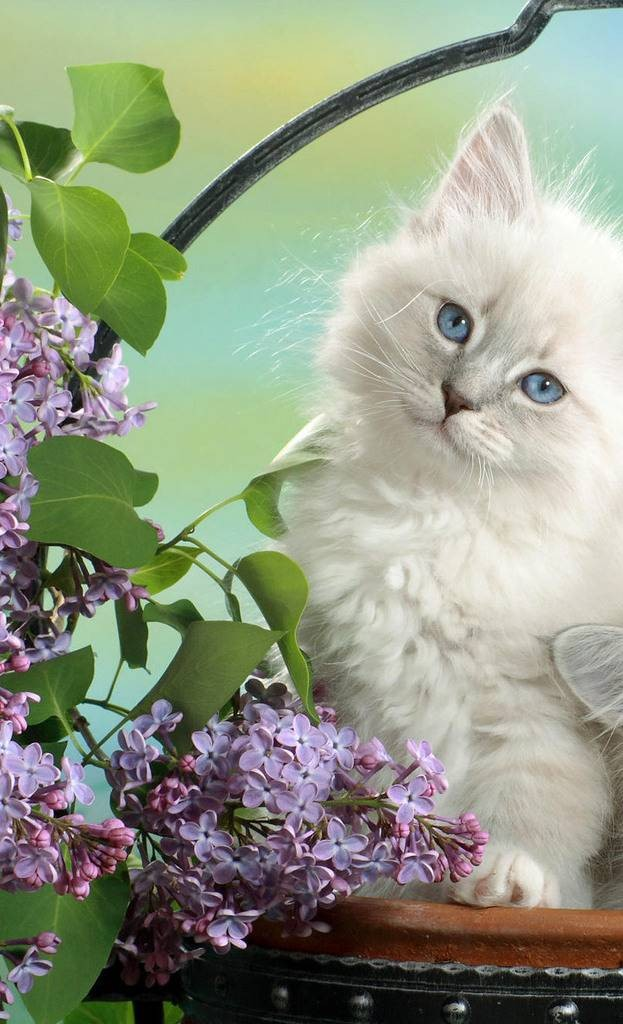

In [ ]:
img_l = cv2.imread('/content/1.jpg')
cv2_imshow(img_l)

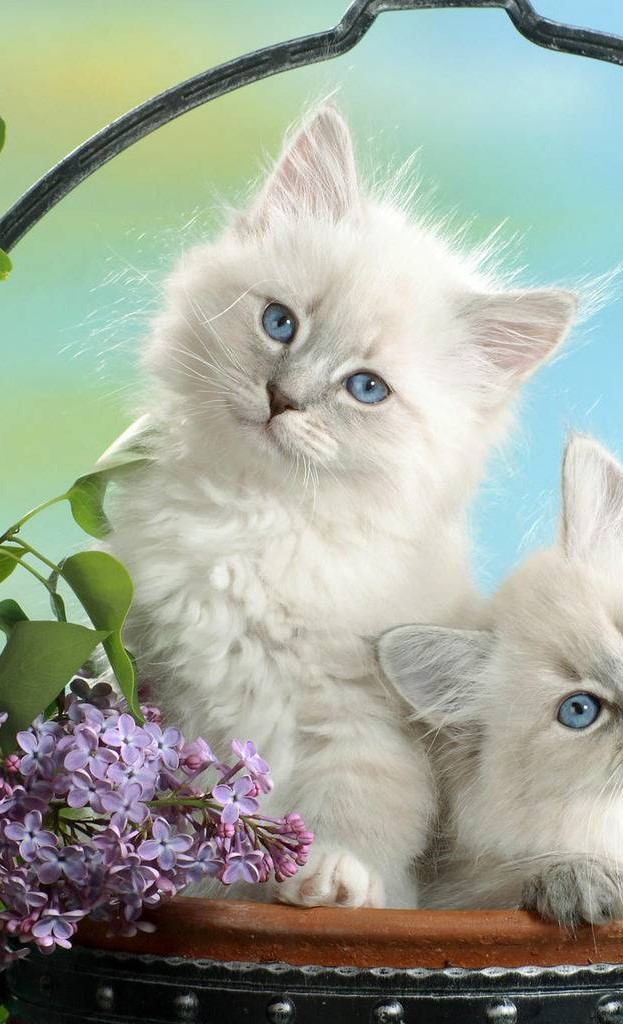

In [ ]:
img_m = cv2.imread('/content/2.jpg')
cv2_imshow(img_m)

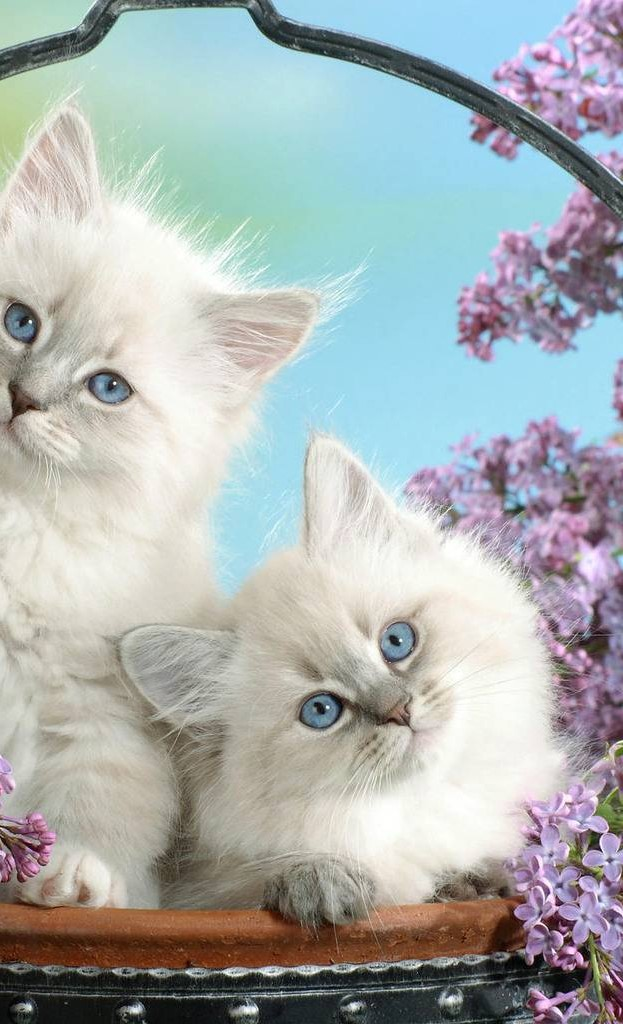

In [ ]:
img_r = cv2.imread('/content/3.jpg')
cv2_imshow(img_r)

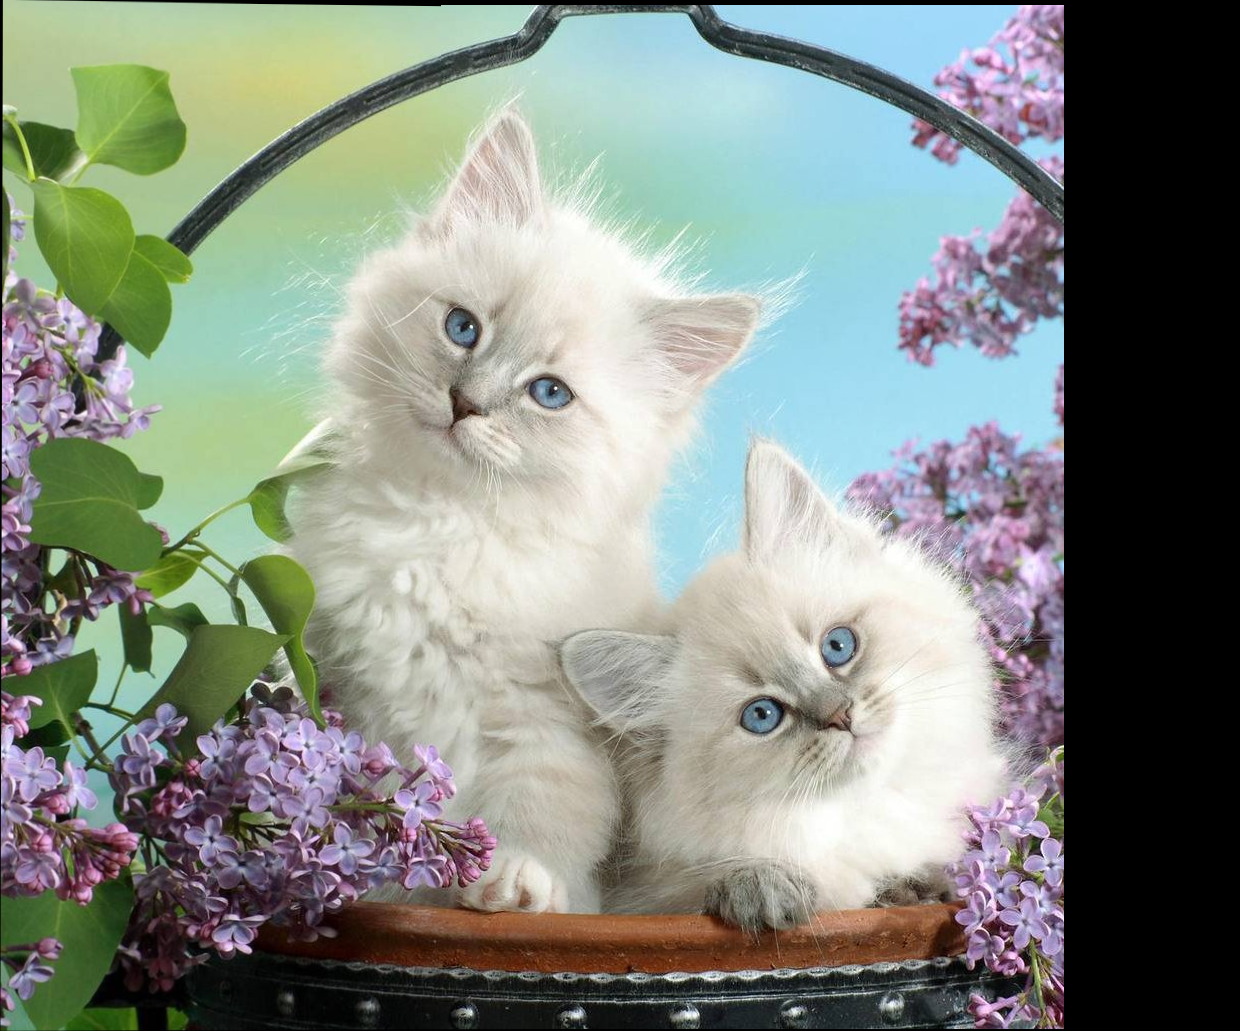

In [ ]:
imgs = [img_l, img_m, img_r]
result = stitch_imgs(imgs)
#cv2.imwrite('panorama.jpg', result)
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()

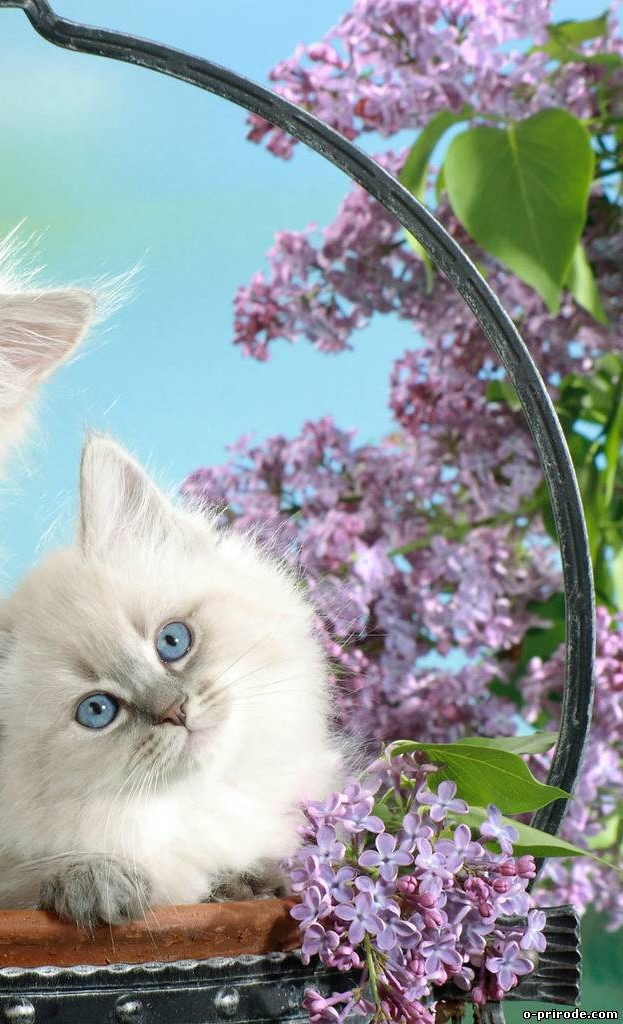

In [ ]:
img_rr = cv2.imread('/content/4.jpg')
cv2_imshow(img_rr)

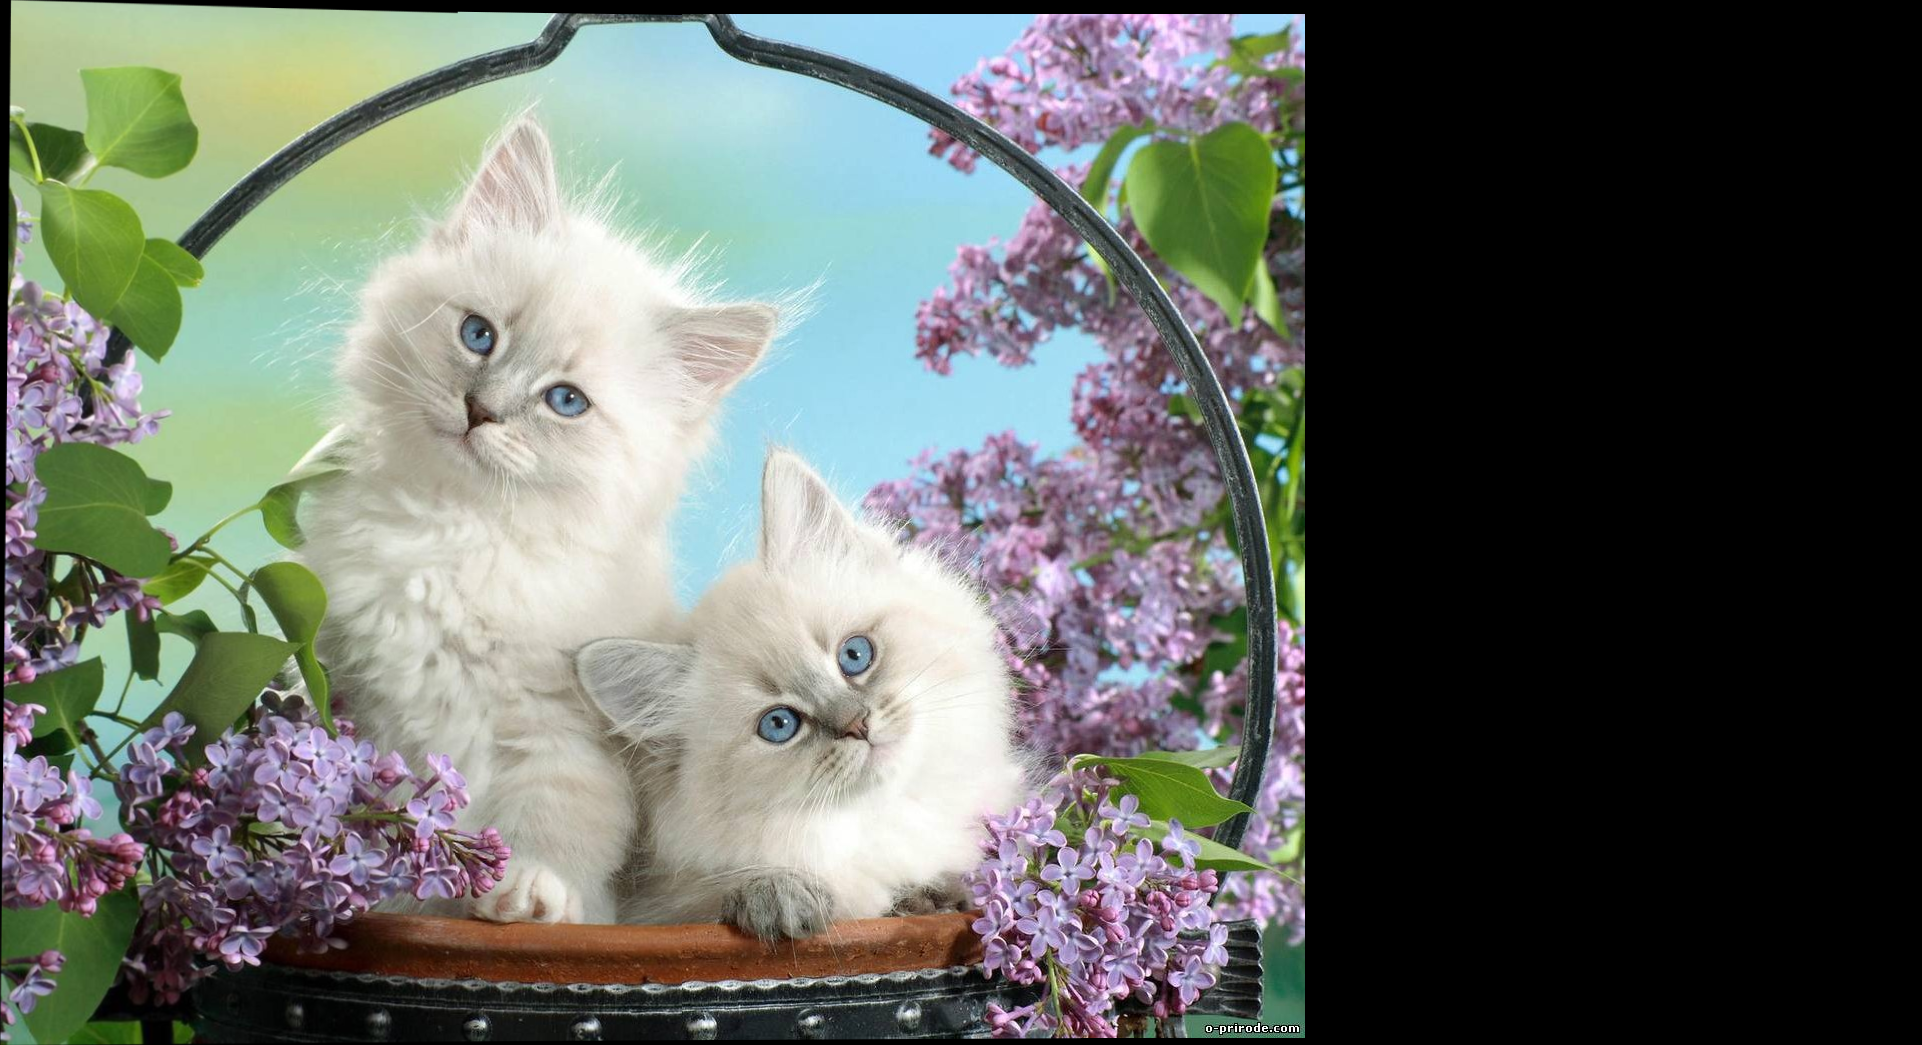

In [ ]:
imgs = [img_l, img_m, img_r, img_rr]
result = stitch_imgs(imgs)
#cv2.imwrite('panorama.jpg', result)
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()